Tahar AMAIRI (CIP : amat0601)
# IFT 870 - Forage de données
## Examen final
### Sommaire
- 1. Score de robustesse R
- 2. Robustesse aux changements de paramètres des algorithmes KMeans et DBSCAN
    - a) Fonction de test
    - b) KMeans
    - c) DBSCAN
- 2. Robustesse à l’ajout de bruit des algorithmes KMeans et DBSCAN
    - a) Fonction de test
    - b) KMeans
    - c) DBSCAN
- 3. Modèle pour la génération du bruit
    - a) Bruit de grenaille
    - b) Fonction de test
    - c) Tests
## Importation des données

In [1]:
# import libs
from sklearn.datasets import fetch_lfw_people
from sklearn.cluster import KMeans, DBSCAN
from matplotlib import pyplot as plt
from itertools import combinations
from collections import Counter
import numpy as np

# Chargement d'un ensemble de données de faces de personnages connus
faces = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

# Reduction du jeu de données à 40 entrées par classe
garder40 = np.zeros(faces.target.shape,dtype=bool)

for nom in np.unique(faces.target):
    garder40[np.where(faces.target==nom)[0][:40]] = 1

X_faces, y_faces, X_images = faces.data[garder40], faces.target[garder40], faces.images[garder40]

## 1. Score de robustesse R

In [2]:
def robustness_score(all_clustering):
    """Compute robustness score

    Args:
        all_clustering (list): Contains the labels for C1,...,CN clustering 

    Returns:
        float: robustness score
    """
    # number of clustering
    N = len(all_clustering)
    # to save all the pairs in the same cluster
    all_pairs = list()

    # iterate over each clustering
    for Ci in all_clustering:
        # get the labels
        labels = np.unique(Ci)
        # iterate over each cluster
        for l in labels:
            # get the points
            cluster = np.where(Ci == l)[0]
            # compute all pairs
            pairs = combinations(cluster, 2)
            # add to all_pairs
            all_pairs += pairs

    # compute the number of appearance of each pairs for each clustering
    P = Counter(all_pairs)
    # return the robustness score
    return sum(P.values()) / (len(P) * N)

## 2. Robustesse aux changements de paramètres des algorithmes KMeans et DBSCAN
### a) Fonction de test

In [3]:
def test_parameters_robustness(X, main_parameter, steps, is_kmeans = True):
    """Test the robustness in the case of parameter variation

    Args:
        X (matrix): data
        main_parameter (int or float): the parameter to be tested and variated
        steps (list): different values to change main_parameter
        is_kmeans (bool, optional): To switch between KMeans and DBSCAN. Defaults to True.
    """
    # to save clustering results
    all_clustering = list()

    # iterate over each step
    for s in steps:
        # create the clustering model
        if is_kmeans:
            model = KMeans(n_clusters=main_parameter+s, random_state=0, n_init=10)
        else:
            model = DBSCAN(eps=main_parameter+s, min_samples=3, n_jobs=-1)

        # train the model
        model.fit(X)

        # get labels
        all_clustering.append(model.labels_)

    # compute robustness score
    R = robustness_score(all_clustering)

    # print
    main_parameter_name = 'n_clusters' if is_kmeans else 'eps'
    print('For {} = {}, the robustness score is {:.4f}'.format(main_parameter_name, main_parameter, R))

Pour information : 
- l'ajout  de l'option ``n_jobs=-1`` pour ``DBSCAN`` permet d'accélérer le temps d'execution en utilisant tous les threads du CPU.
### b) KMeans

In [4]:
steps = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
number_clusters = [40,60,80]

for k in number_clusters:
    test_parameters_robustness(X_faces, k, steps)

For n_clusters = 40, the robustness score is 0.2321
For n_clusters = 60, the robustness score is 0.2077
For n_clusters = 80, the robustness score is 0.2024


Le modèle le plus robuste suivant le score R est celui avec $k = 40$. Par ailleurs, on remarque que les scores sont relativement proches surtout pour les valeurs $k = 60$ et $k = 80$.

### c) DBSCAN

In [5]:
steps =  [-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5]
eps = [7,8,9]

for e in eps:
    test_parameters_robustness(X_faces, e, steps, is_kmeans=False)

For eps = 7, the robustness score is 0.9477
For eps = 8, the robustness score is 0.8442
For eps = 9, the robustness score is 0.7348


Le modèle le plus robuste suivant le score R est celui avec $eps = 7$. On remarque aussi que ``DBSCAN`` possède généralement une meilleure robustesse que ``KMeans``.

## 2. Robustesse à l’ajout de bruit des algorithmes KMeans et DBSCAN
### a) Fonction de test

In [6]:
def test_noise_robustness(X, main_parameter, ratio, is_kmeans = True):
    """Test the robustness in the case of added noise

    Args:
        X (matrix): data
        main_parameter (int or float): the parameter to be tested and variated
        ratio (int): the ratio to get the noise size
        is_kmeans (bool, optional): To switch between KMeans and DBSCAN. Defaults to True.
    """
    # compute mean and std of each dimension
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    # number of dimension
    number_dimension = len(mean)
    # noise size
    noise_size = int(ratio * len(X) / 100)
    # to save clustering results
    all_clustering = list()

    # create the clustering model
    if is_kmeans:
        model = KMeans(n_clusters=main_parameter, random_state=0, n_init=10)
    else:
        model = DBSCAN(eps=main_parameter, min_samples=3, n_jobs=-1)

    # with noise
    for _ in range(10):
        # generate noise
        noise = np.random.normal(mean, std, (noise_size,number_dimension))

        # concat the noise to X
        X_noise = np.concatenate((X,noise),axis=0)
        
        # train the model
        model.fit(X_noise)

        # get labels
        all_clustering.append(model.labels_)

    # without noise
    model.fit(X)
    all_clustering.append(model.labels_)
    
    # compute robustness score
    R = robustness_score(all_clustering)

    # print
    main_parameter_name = 'n_clusters' if is_kmeans else 'eps'
    print('For {} = {}, the robustness score is {:.4f}'.format(main_parameter_name, main_parameter, R))

### b) KMeans

In [7]:
number_clusters = [40,60,80]

for k in number_clusters:
    test_noise_robustness(X_faces, k, 5, steps)

For n_clusters = 40, the robustness score is 0.2575
For n_clusters = 60, the robustness score is 0.2370
For n_clusters = 80, the robustness score is 0.2247


En ajoutant du bruit, la différence de score de robustesse entre les modèles est beaucoup plus mimine que pour le premier test. Cependant, le modèle le plus robuste suivant le score R est toujours celui avec $k = 40$. Finalement, avec l'ajout du bruit, ``KMeans`` semble ne pas être toujours assez robuste au vu des faibles scores obtenus et par ailleurs, si on se base sur les deux tests : le modèle avec $k = 40$ semble le plus pertinent.

### c) DBSCAN

In [8]:
eps = [7,8,9]

for e in eps:
    test_noise_robustness(X_faces, e, 5, is_kmeans=False)

For eps = 7, the robustness score is 0.9914
For eps = 8, the robustness score is 0.9905
For eps = 9, the robustness score is 0.9900


De même ici, la différence est plus que négligeable et ``DBSCAN`` performe très bien avec une robustesse presque parfaite. Cependant, le meilleur modèle est celui avec $eps = 7$. En prenant en compte le premier test, on peut conclure que le modèle le plus pertinent est obtenu avec $eps = 7$.

## 3. Modèle pour la génération du bruit
### a) Bruit de grenaille

Lors de l'acquisition et de la transmission d'une image, du bruit peut être introduit et cette introduction peut être causée par plusieurs facteurs :
- Facteurs environnementaux
- Une faible luminosité et la température du capteur peuvent provoquer un bruit d'image. 
- Les particules de poussière dans le scanner peuvent provoquer du bruit dans l'image numérique. 
- Interférence du canal de transmission

Il existe donc une pléthore de bruit possible qu'on peut rencontrer dans le domaine de l'imagerie : bruit gaussien (vu à la question précédente), bruit speckle (très répandu dans l'imagerie médicale), bruit de grenaille etc...

Dans notre cas, nous allons implémenter le ``bruit de grenaille`` qui est un bruit de fond pouvant être modélisé par un processus de ``Poisson``. Cela s'explique lors du processus d'arrivée des photons : lorsque les photons d'une source lumineuse atteignent le capteur d'un appareil photo, ils sont détectés sous forme d'événements discrets. Cependant, le nombre de photons détectés varie de manière aléatoire, ce qui entraîne un bruit de fond dans le signal pouvant être modélisé par une loi de ``Poisson``. L'implementation de ce phénomène numériquement va donc se baser sur les valeurs des pixels de l'image directement afin de générer du bruit suivant une loi de ``Poisson``. 

Par conséquent, ce bruit est très fréquent et son ajout est tout à fait cohérent avec le type de données qu'on essaye de segmenter.

In [9]:
def poisson_noise(X):
    """Add poisson noise to X

    Args:
        X (matrix): data

    Returns:
        matrix: data noised with poisson noise
    """
    # number of image in X
    number_image = X.shape[0]
    
    # iterate over each image
    for i in range(number_image):
        # add poisson noise
        vals = 2 ** np.ceil(np.log2(len(np.unique(X[i]))))
        X[i] = np.random.poisson(X[i] * vals) / float(vals)

    return X

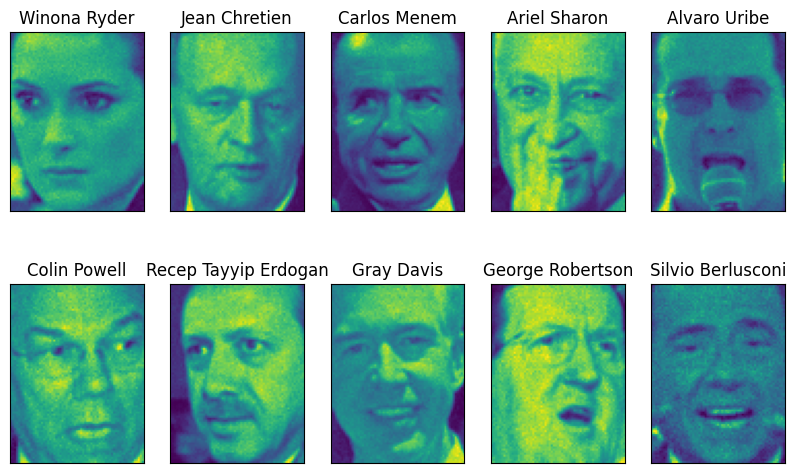

In [10]:
# get poisson noise
X_poisson_noise = poisson_noise(X_faces.copy())

# show image noised
fig, axes = plt.subplots(2, 5, figsize=(10, 6), subplot_kw={'xticks': (), 'yticks': ()})
for i, (nom, ax) in enumerate(zip(faces.target, axes.ravel())):
    ax.imshow(X_poisson_noise[i].reshape((87, 65)))
    ax.set_title(faces.target_names[nom])

On remarque les images sont légèrement bruitées et granulées.
### b) Fonction de test
Pour la méthode de test, on peut s'inspirer de celle de la question précédente afin de générer $n$ fois des images bruitées par un processus de ``Poisson``. Dans notre cas, on va prendre $n = 11$ pour pouvoir comparer avec les résultats de la question précédente. Cependant, ici, nous n'ajouterons pas de données non-bruitées à la fin car le ``bruit de grenaille`` est introduit naturellement à chaque prise d'une image, il est donc plus cohérent qu'il soit toujours présent. Pour la même raison, on ne concaténera pas de bruit à l'image directement car le ``bruit de grenaille`` modifie directement l'image et donc la valeur des pixels de l'image.

In [11]:
def test_poisson_noise_robustness(X, main_parameter, is_kmeans = True):
    """Test the robustness in the case of added poisson noise

    Args:
        X (matrix): data
        main_parameter (int or float): the parameter to be tested and variated
        is_kmeans (bool, optional): To switch between KMeans and DBSCAN. Defaults to True.
    """
    # to save clustering results
    all_clustering = list()

    # create the clustering model
    if is_kmeans:
        model = KMeans(n_clusters=main_parameter, random_state=0, n_init=10)
    else:
        model = DBSCAN(eps=main_parameter, min_samples=3, n_jobs=-1)

    # with noise
    for _ in range(11):
        # get poisson noise
        X_noise = poisson_noise(X)
        
        # train the model
        model.fit(X_noise)

        # get labels
        all_clustering.append(model.labels_)

    # compute robustness score
    R = robustness_score(all_clustering)

    # print
    main_parameter_name = 'n_clusters' if is_kmeans else 'eps'
    print('For {} = {}, the robustness score is {:.4f}'.format(main_parameter_name, main_parameter, R))

### c) Tests

In [12]:
# KMeans
number_clusters = [40,60,80]

for k in number_clusters:
    test_poisson_noise_robustness(X_faces, k)

For n_clusters = 40, the robustness score is 0.2311
For n_clusters = 60, the robustness score is 0.2009
For n_clusters = 80, the robustness score is 0.1864


In [13]:
eps = [7,8,9]

for e in eps:
    test_poisson_noise_robustness(X_faces, e, is_kmeans=False)

For eps = 7, the robustness score is 1.0000
For eps = 8, the robustness score is 1.0000
For eps = 9, the robustness score is 1.0000


Au vu des résultats, on obtient la même conclusion que pour les deux premiers. En effet, pour ``KMeans``, le modèle avec la meilleure robustesse est celui avec $k = 40$. Concernant ``DBSCAN``, il obtient une parfaite robustesse pour tous les modèles.

En conclusion, les meilleurs modèles concernant la robustesse à travers ces 3 tests (variation de paramètre, bruit gaussien, bruit de grenaille) sont : 
- ``KMeans`` : $k = 40$
- ``DBSCAN`` : $eps = 7$

$\rightarrow$ Meilleur algorithme de clustering en terme de robustesse : ``DBSCAN``